# Introduction
_Rodrigo Schmitt_

**CMC-303-4: Artificial Satellites - Orbital Movement**

**Professors: Hélio Kuga, Antônio Bertachini and Valdemir Carrara**

This notebook serves as the final project of INPE's CMC-303-4 graduate course (Artificial Satellites - Orbital Movement). 

It aims to document the implementation of three new functions in [RocketPy](https://github.com/Projeto-Jupiter/RocketPy/tree/master/rocketpy), Projeto Jupiter's rocket trajectory library.



## Context
Contextualizing, [RocketPy](https://github.com/Projeto-Jupiter/RocketPy/tree/master/rocketpy) is a new open-source Python library specialized in trajectory simulations of sounding rockets and similar launch vehicles.
Having a modular structure and being built on top of a six degree-of-freedom flight dynamics model which includes detailed mass variation effects, it allows for accurate trajectory prediction of different rocket configurations.
Additionally, weather data from several meteorological agencies, such as reanalysis, forecasts and ensembles, are directly integrated into the library, providing precise information about atmospheric conditions for each simulation.
The software has already been successfully validated for three launch vehicles developed by different universities, with apogee predictions showing deviations of the order of 1% when compared to actual flight data.
Furthermore, due to its library nature, RocketPy can be easily used in optimization studies and Monte Carlo analyses that enable the calculation of landing dispersion ellipses based on input uncertainties.


## Functions
My intention here is to further advance this library, which has already yielded a publication (currently under review for the Journal of Aerospace Engineering), by writing algorithms of orbit prediction with gravitational perturbations, allowing for a step beyond trajectory analysis. To that end, I will develop, describe and test three new functions here: `transformToEquatorial`, `gravity` and `transformToLocal`.

### `transformToEquatorial`
The **Local frame**, denoted by `(x, y, z)`, is used in the program as the main reference frame in which every force acts on the rocket, be it thrust, lift, drag, wind... It is the system centered in the launch site, whose z axis points perpendicular to the Earth and x and y point to east and north, respectively. This frame makes it much easier to implement the rocket's dynamical models locally.

The function `transformToEquatorial` is, then, responsible for transforming the rocket's position vector from the Local frame to the **Equatorial frame**, denoted by `(X, Y, Z)`, which is Earth's inertial frame in which we'll implement the gravitational acceleration function. This frame is centered at the centre of the Earth and its fundamental plane is the plane of the Earth's equator, with the z-axis pointing along the north polar axis.

### `gravity`
The next step is to used the newly transformed rocket's position coordinates, returned from the `transformToEquatorial` function above, to generate a robust gravitational model.

This function, hence, uses the zonal coefficients up to the $6^{th}$ order to return the gravity vector `(gX, gY, gZ)`, in the Equatorial frame, which will act on the rocket.

### `transformToLocal`
The final step is to transform the gravity vector `(gX, gY, gZ)` above, to the Local frame. This is done so that the gravity vector can be added to the remaining accelerations (due to other forces) and be used to integrate the rocket's state vector (position, velocity, quaternions and angular velocity) in the Local frame.

# `transformToEquatorial` function

This section aims to develop and test the `transformToEquatorial` function used in [RocketPy](https://github.com/Projeto-Jupiter/RocketPy/tree/master/rocketpy).


* * *

## About

The function should transform a position vector from the Local to the Equatorial coordinate system, where:

- Local system:
    - Origin at the launch rail,
    - X-axis: coordinate due east,
    - Y-axis: coordinate due north,
    - Z-axis: coordinate perpendicular to the ground.
- Equatorial coordinate system:
    - Origin at the centre of the Earth,
    - The fundamental plane in the plane of the Earth's equator.
    - X-axis: coordinate toward the vernal equinox,
    - Y-axis: A right-handed convention, specifying a y axis 90° to the east in the fundamental plane, and 
    - Z-axis: coordinate along the north polar axis.
- Geocentric (GEOC) system:
    - Origin at the centre of the Earth,
    - The fundamental plane in the plane of the Earth's equator.
    - X-axis: Points to Greenwich meridian and is in the equatorial plane.
    - Y-axis: Completes the handed orthogonal set,
    - Z-axis: Coincident with the Earth's rotational axis.
        
----

## Info

https://en.wikipedia.org/wiki/Equatorial_coordinate_system

----

## Parameters
x, y, z : floats

    Position vector in local coordinates.

----------

## Returns
X, Y, Z : floats

    Position vector in the Equatorial coordinate system.
    
R_xyz_XYZ: np.array(3,3)
        
    Rotation matrix from Local to Equatorial frame

-------

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt

### Initial parameters

In [2]:
# Get current lat, lon and elevation
latitude = 45*np.pi/180
longitude = 60*np.pi/180
elevation = 1000 #m
colatitude = np.pi/2 - latitude

z = elevation

In [3]:
# Get parameters regarding Earth's flattening
r_e = 6378.137*1000 # Earth's equatorial radius, m
f = 1/298.257 # flattening factor of Earth
b = r_e - r_e*f # Earth's polar radius, m
e =  (r_e**2 - b**2)**(1/2) / r_e # Earth's first eccentricity 
N = r_e*(1 - f*(2 - f)* np.sin(latitude)**2)**(-1/2) # the radius of curvature in the prime vertical 

### First transformation: GEOC frame

In [4]:
''' Geocentric (GEOC) frame:
Origin at the centre of the Earth,
The fundamental plane in the plane of the Earth's equator.
X-axis: Points to Greenwich meridian and is in the equatorial plane.
Y-axis: Completes the handed orthogonal set
Z-axis: Coincident with the Earth's rotational axis
'''

# Transformation to Geocentric frame
X_GEOC = (N + z)*np.sin(colatitude)*np.cos(longitude)
Y_GEOC = (N + z)*np.sin(colatitude)*np.sin(longitude)
Z_GEOC = (N*(1-e**2) + z)*np.cos(colatitude)

In [5]:
print("Coordinates of the launch site:\n", X_GEOC, Y_GEOC, Z_GEOC, 'm')

Coordinates of the launch site:
 2259148.995653388 3912960.8423398677 4488055.498655134 m


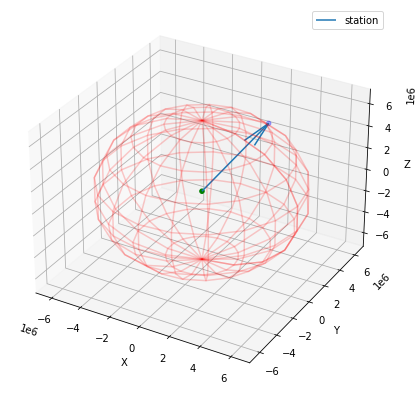

In [6]:
fig = plt.figure(figsize=(15,7 ))
ax = fig.add_subplot(111, projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = r_e*np.cos(u)*np.sin(v)
y_sphere = r_e*np.sin(u)*np.sin(v)
z_sphere = r_e*np.cos(v)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="r", alpha=0.2)

# draw vector
ax.scatter([0, X_GEOC], [0, Y_GEOC], [0, Z_GEOC], c=['green', 'blue'])
ax.quiver(0,0,0,X_GEOC,Y_GEOC,Z_GEOC,length=1.0, label='station')

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.legend()

### Greenwich Mean Sidereal Time

Source: [_Meeus, J., 2000. Astronomical Algorithms. Willman-Bell, Richmond,VA, 2nd ed._,Chapter 12](http://www.agopax.it/Libri_astronomia/pdf/Astronomical%20Algorithms.pdf)

In [7]:
# The Greenwich Mean Sidereal Time is defined by the hour angle between the meridian of Greenwich
# and mean equinox of date at 0h UT1
ut1 = dt.datetime(1987, 4, 10, 19, 21, 0)
year, month, day = ut1.year, ut1.month, ut1.day
hour, minute, second = ut1.hour, ut1.minute, ut1.second
if month < 3:
    year  -= 1
    month += 12
JD  = int(365.25 * year) \
        + year // 400 \
        - year // 100 \
        + int(30.59 * (month - 2)) \
        + day \
        + 1721088.5
t  = (second / 3600 \
       + minute / 60 \
       + hour) / 24.0
JD += t

# Universal time
Tu = (JD-2451545.0)/36525

# Greenwich Mean Sidereal Time in degrees
GMST = 280.460618375 + 360.9856473663*(JD-2451545.0) + 0.000388*Tu**2

while GMST>360:
    GMST -= 360
while GMST<0:
    GMST += 360
    
# Convert to radians
GMST *= np.pi/180

In [8]:
# Transformation from Geocentric to Equatorial frame
M = np.array(([np.cos(GMST), np.sin(GMST), 0],
             [-np.sin(GMST), np.cos(GMST), 0],
             [0, 0, 1]))
X_station_vec = M@np.array([X_GEOC, Y_GEOC, Z_GEOC]).reshape(3,)

In [9]:
print('Transformed station vector:\n', X_station_vec, 'm')

Transformed station vector:
 [ 1638494.3113274  -4210742.5865273   4488055.49865513] m


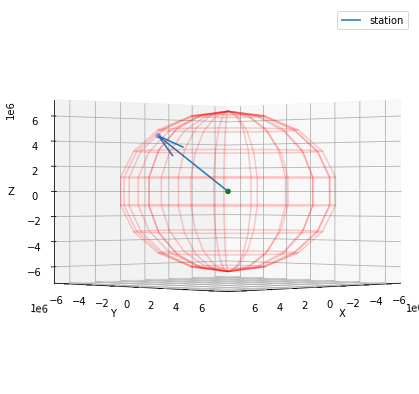

In [10]:
fig = plt.figure(figsize=(15,7 ))
ax = fig.add_subplot(111, projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = r_e*np.cos(u)*np.sin(v)
y_sphere = r_e*np.sin(u)*np.sin(v)
z_sphere = r_e*np.cos(v)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="r", alpha=0.2)

# draw vector
ax.scatter([0, X_station_vec[0]], [0, X_station_vec[1]], [0, X_station_vec[2]], c=['green', 'blue'])
ax.quiver(0,0,0,X_station_vec[0],X_station_vec[1],X_station_vec[2],length=1.0, label='station')

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.view_init(0, 45)


plt.legend()
plt.show()

It seems perfect. After all, the station vector should still be slightly outside the Earth, here represented by the red spherical grid.

### Second transformation: Equatorial frame

In [11]:
# Rotation matrix from Local to Equatorial frame
# Align z by rotating in the x-axis by an angle of colatitude
Rx = np.array(([1, 0, 0],
             [0, np.cos(-colatitude), np.sin(-colatitude)],
             [0, -np.sin(-colatitude), np.cos(-colatitude)]))

# Align x and y by rotating in the z-axis by an angle of rot_angle
rot_angle = (-np.pi/2 - longitude + GMST)
Rz = np.array(([np.cos(rot_angle), np.sin(rot_angle), 0],
             [-np.sin(rot_angle), np.cos(rot_angle), 0],
             [0, 0, 1]))
R_xyz_XYZ = Rz@Rx

## Tests
Here, I'll test whether the rotation actually works on a few simple vectors.

1. The first one shall have only a **z component** on the Local frame, which means that it will be slightly **above** the station location (that is, perpendicular to the Earth) when we transform it to the Equatorial frame and plot its vector (red) against the station vector (blue).
2. The second one shall have only a **y component** on the Local frame, which means that it will be slightly **north** from the station location (that is, still in/near the Earth's surface) when we transform it to the Equatorial frame and plot its vector (red) against the station vector (blue).
2. The third one shall have only an **x component** on the Local frame, which means that it will be slightly **east** from the station location (that is, still in/near the Earth's surface) when we transform it to the Equatorial frame and plot its vector (red) against the station vector (blue).

### Test 1: 2000 km perpendicular (z)

The rocket position, originally (0, 0, 2000000.0) m in the Local frame, is now:
 [ 2151338.05943978 -5528692.24035405  5902269.06102823] m


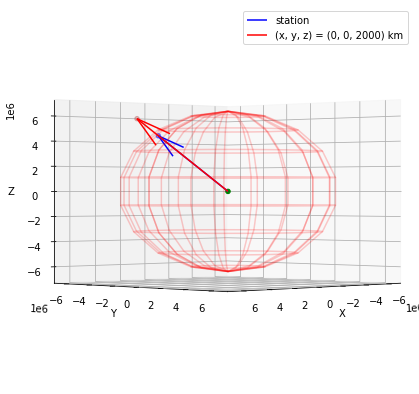

In [12]:
# Initializing rocket's coordinates in the Local frame
x = 0
y = 0
z = 2e6

# Rocket Coordinate transformation: from Local to Equatorial frame
X_rocket_vec = R_xyz_XYZ@np.array([x, y, z])

# Rocket position
X_vec = X_station_vec + X_rocket_vec

print(f"The rocket position, originally ({x}, {y}, {z}) m in the Local frame, is now:\n", X_vec, 'm')

fig = plt.figure(figsize=(15,7 ))
ax = fig.add_subplot(111, projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = r_e*np.cos(u)*np.sin(v)
y_sphere = r_e*np.sin(u)*np.sin(v)
z_sphere = r_e*np.cos(v)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="r", alpha=0.2)

# draw vector
ax.scatter([0, X_station_vec[0], X_vec[0]], [0, X_station_vec[1], X_vec[1]], [0, X_station_vec[2], X_vec[2]], \
           c=['green', 'blue', 'brown'])
ax.quiver(0,0,0,X_station_vec[0],X_station_vec[1],X_station_vec[2],length=1.0, color='blue', label='station')

# draw vector
#ax.scatter([X_vec[0]], [X_vec[1]], [X_vec[2]], c='brown')
ax.quiver(0,0,0 ,X_vec[0],X_vec[1],X_vec[2],length=1.0, color='red', label=f"(x, y, z) = ({x/1e3:.0f}, {y/1e3:.0f}, {z/1e3:.0f}) km")

ax.view_init(0, 45)


# Labels

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

This looks pretty good, since it is aligned with the original vector of the station.

Now for the next:

### Test 2: 2000 km up (y)

The rocket position, originally (0, 2000000.0, 0) m in the Local frame, is now:
 [ 1125650.56321503 -2892792.93270054  5902269.06102823] m


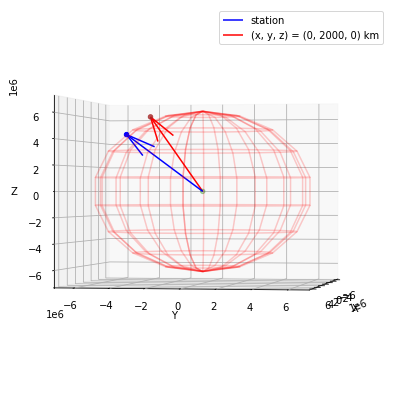

In [13]:
# Initializing rocket's coordinates in the Local frame
x = 0
y = 2e6
z = 0


# Rocket Coordinate transformation: from Local to Equatorial frame
X_rocket_vec = R_xyz_XYZ@np.array([x, y, z])

# Rocket position
X_vec = X_station_vec + X_rocket_vec

print(f"The rocket position, originally ({x}, {y}, {z}) m in the Local frame, is now:\n", X_vec, 'm')

fig = plt.figure(figsize=(15,7 ))
ax = fig.add_subplot(111, projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = r_e*np.cos(u)*np.sin(v)
y_sphere = r_e*np.sin(u)*np.sin(v)
z_sphere = r_e*np.cos(v)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="r", alpha=0.2)

# draw vector
ax.scatter([0, X_station_vec[0], X_vec[0]], [0, X_station_vec[1], X_vec[1]], [0, X_station_vec[2], X_vec[2]], \
           c=['green', 'blue', 'brown'])
ax.quiver(0,0,0,X_station_vec[0],X_station_vec[1],X_station_vec[2],length=1.0, color='blue', label='station')

# draw vector
#ax.scatter([X_vec[0]], [X_vec[1]], [X_vec[2]], c='brown')
ax.quiver(0,0,0 ,X_vec[0],X_vec[1],X_vec[2],length=1.0, color='red', label=f"(x, y, z) = ({x/1e3:.0f}, {y/1e3:.0f}, {z/1e3:.0f}) km")

ax.view_init(0, 10)


# Labels

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

Also pretty good, since it is north from the station.

Finally:

### Test 3: 2000 km left (x)

The rocket position, originally (2000000.0, 0, 0) m in the Local frame, is now:
 [ 3502356.58629412 -3485472.00256853  4488055.49865513] m


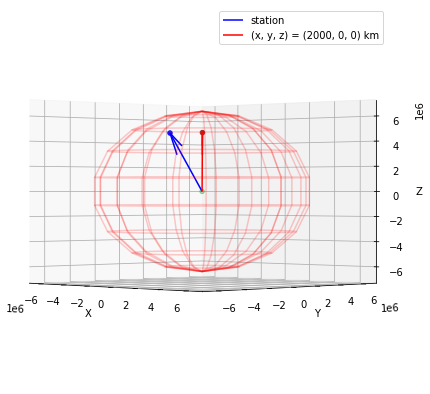

In [14]:
# Initializing rocket's coordinates in the Local frame
x = 2e6
y = 0
z = 0

# Rocket Coordinate transformation: from Local to Equatorial frame
X_rocket_vec = R_xyz_XYZ@np.array([x, y, z])

# Rocket position
X_vec = X_station_vec + X_rocket_vec

print(f"The rocket position, originally ({x}, {y}, {z}) m in the Local frame, is now:\n", X_vec, 'm')

fig = plt.figure(figsize=(15,7 ))
ax = fig.add_subplot(111, projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = r_e*np.cos(u)*np.sin(v)
y_sphere = r_e*np.sin(u)*np.sin(v)
z_sphere = r_e*np.cos(v)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="r", alpha=0.2)

# draw vector
ax.scatter([0, X_station_vec[0], X_vec[0]], [0, X_station_vec[1], X_vec[1]], [0, X_station_vec[2], X_vec[2]], \
           c=['green', 'blue', 'brown'])
ax.quiver(0,0,0,X_station_vec[0],X_station_vec[1],X_station_vec[2],length=1.0, color='blue', label='station')

# draw vector
#ax.scatter([X_vec[0]], [X_vec[1]], [X_vec[2]], c='brown')
ax.quiver(0,0,0 ,X_vec[0],X_vec[1],X_vec[2],length=1.0, color='red', label=f"(x, y, z) = ({x/1e3:.0f}, {y/1e3:.0f}, {z/1e3:.0f}) km")

ax.view_init(0, -45)


# Labels

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

Perfect as well, since it is east from the station.

## Conclusion

Since all three vectors are transformed correctly, we can assure that the function was built correctly and move for the next one! 

PS. This was the result of many, many attempts with other tests as well.


***

# `gravity` function

This section aims to test the `gravity` function implemented in [RocketPy](https://github.com/Projeto-Jupiter/RocketPy/tree/master/rocketpy).

* * *

## About

This function calculates the gravitational acceleration vector based on position vector in the Equatorial frame.
It uses the geopotential zonal coefficients up to the $6^{th}$ order.
        

----

## Parameters

X, Y, Z : floats
    
    Position vector in Local coordinates.


----------

## Returns
gX, gY, gZ : floats
    
    Acceleration vector in Equatorial coordinate system.

-------

## Code

### Initial parameters

In [15]:
# To test, let's pick X, Y and Z from the last X_vec parameter
X = X_vec[0]
Y = X_vec[1]
Z = X_vec[2]

# Norm in meters
r = np.sqrt(X**2+Y**2+Z**2)

print("The current position vector is: \n(", X, Y, Z, ') m')

The current position vector is: 
( 3502356.5862941192 -3485472.0025685253 4488055.498655134 ) m


In [16]:
# Initializing geopotential coefficients
J2 = 1082.64e-6
J3 = -2.5e-6
J4 = -1.6e-6
J5 = -0.15e-6
J6 = 0.57e-6
J7 = -0.44e-6

In [17]:
mu = 3.986004418e14 # m^3 s−2
r_e = 6378.137*1000 # Earth's equatorial radius, m

### Gravitational acceleration

According to [Bate, Muller and White](http://cmp.felk.cvut.cz/~kukelova/pajdla/Bate,%20Mueller,%20and%20White%20-%20Fundamentals%20of%20Astrodynamics.pdf):
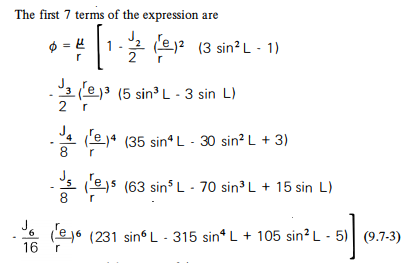

which gives us:
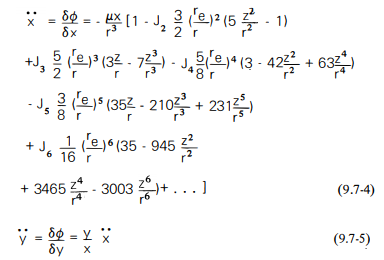
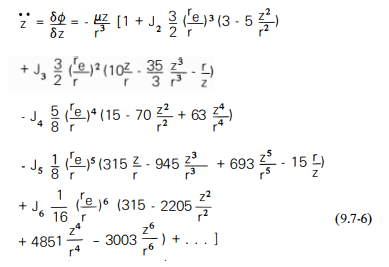

In [18]:
gX = - mu*X/r**3* (1 - J2*(3/2*(r_e/r)**2)*(5*(Z/r)**2 - 1)
                    + J3*5/2*(r_e/r)**3*(3*(Z/r) - 7*(Z/r)**3)
                    - J4*5/8*(r_e/r)**4*(3 - 42*(Z/r)**2 + 63*(Z/r)**4)
                    + J5*3/8*(r_e/r)**5*(35*(Z/r) - 210*(Z/r)**3 + 231*(Z/r)**5)
                    + J6*1/16*(r_e/r)**6*(35 - 945*(Z/r)**2 + 3465*(Z/r)**4 - 3003*(Z/r)**6))

gY = Y/X*gX

gZ = - mu*Z/r**3* (1 + J2*(3/2*(r_e/r)**3)*(3 - 5*(Z/r)**2)
                    + J3*3/2*(r_e/r)**2*(10*(Z/r) - 35/3*(Z/r)**3 - (r/Z))
                    - J4*5/8*(r_e/r)**4*(15 - 70*(Z/r)**2 + 63*(Z/r)**4)
                    + J5*1/8*(r_e/r)**5*(315*(Z/r) - 945*(Z/r)**3 + 693*(Z/r)**5 - 15*(r/Z))
                    + J6*1/16*(r_e/r)**6*(315 - 2205*(Z/r)**2 + 4851*(Z/r)**4 - 3003*(Z/r)**6))

print("The gravitational acceleration, in the Equatorial coordinate system, is:\n", gX, gY, gZ, 'm/s²')
print("Its norm is:\n", np.linalg.norm(np.array([gX, gY, gZ])), 'm/s²')

The gravitational acceleration, in the Equatorial coordinate system, is:
 -4.684918847263242 4.662333224533168 -6.020933672523916 m/s²
Its norm is:
 8.940775021828953 m/s²


## Tests

The gravity vector should point to the center of the Earth.

Hence, here I'll plot it with the other vectors above, to verify whether that actually happens.

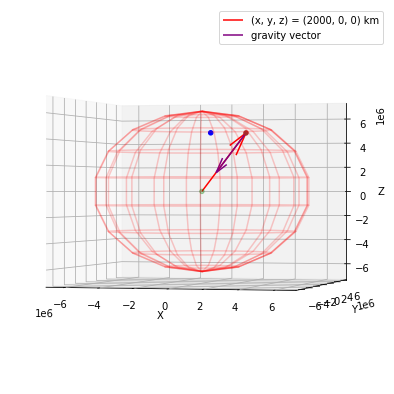

In [19]:
fig = plt.figure(figsize=(15,7 ))
ax = fig.add_subplot(111, projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = r_e*np.cos(u)*np.sin(v)
y_sphere = r_e*np.sin(u)*np.sin(v)
z_sphere = r_e*np.cos(v)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color="r", alpha=0.2)

# draw vector
ax.scatter([0, X_station_vec[0], X_vec[0]], [0, X_station_vec[1], X_vec[1]], [0, X_station_vec[2], X_vec[2]], \
           c=['green', 'blue', 'brown'])
#ax.quiver(0,0,0,X_station_vec[0],X_station_vec[1],X_station_vec[2],length=1.0, color='blue', label='station')

# draw vector
#ax.scatter([X_vec[0]], [X_vec[1]], [X_vec[2]], c='brown')
ax.quiver(0,0,0 ,X_vec[0],X_vec[1],X_vec[2],length=1.0, color='red', label=f"(x, y, z) = ({x/1e3:.0f}, {y/1e3:.0f}, {z/1e3:.0f}) km")


# gX, gY and gZ are multiplied by 0.5e6 to be in the same order of X_vec, so we can visualize them all
ax.quiver(X_vec[0],X_vec[1],X_vec[2] ,gX*0.5e6,gY*0.5e6,gZ*0.5e6,length=1.0, color='purple', label=f"gravity vector")


ax.view_init(0, -75)


# Labels

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

plt.show()

And it's pointing towards Earth's center!

Nothing unusual here, we can go to the final function now.

# `transformToLocal` function

This section aims to develop and test the `transformToLocal` function used in [RocketPy](https://github.com/Projeto-Jupiter/RocketPy/tree/master/rocketpy).


* * *

## About

The function should transform an acceleration vector from the Equatorial to the Local coordinate system, where:

- Local system:
    - Origin at the launch rail,
    - X-axis: coordinate due east,
    - Y-axis: coordinate due north,
    - Z-axis: coordinate perpendicular to the ground.
- Equatorial coordinate system:
    - Origin at the centre of the Earth,
    - The fundamental plane in the plane of the Earth's equator.
    - X-axis: coordinate toward the vernal equinox,
    - Y-axis: A right-handed convention, specifying a y axis 90° to the east in the fundamental plane, and 
    - Z-axis: coordinate along the north polar axis.
        

----

## Parameters
gX, gY, gZ : floats

    Acceleration vector in Equatorial coordinate system.
    
X, Y, Z : floats

    Position vector in Equatorial coordinates, in meters.
    
vx, vy, vz : floats

    Velocity vector in Local coordinates, in m/s.
    
R_xyz_XYZ: np.array(3,3)

    Rotation matrix from Local to Equatorial frame.

----------

## Returns
gx, gy, gz : floats

    Acceleration vector in Local coordinate system.

-------

## Code

Because of the perceived effects from the Earth's rotation, we need to take into account the apparent forces when we transform the acceleration back from the Equatorial to the Local frame.

In the right-hand side, we have the real forces that act upon our rocket, while in the left-hand side, we have the forces that need to be taken into account. 

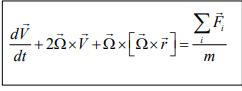

In other words, our acceleration in the Local frame will be given by the left-hand side of the equation above.

$$\vec{a}_{xyz} = \frac{\vec{F_R}}{m} - 2 \vec{\Omega} \times \vec{v}_{xyz} - \vec{\Omega} \times (\vec{\Omega} \times \vec{r}_{xyz}) + \vec{g}_{xyz}$$

In [20]:
# Rocket's position vector in Local frame
x_rocket_local = np.array([x, y, z]) # Rocket position vector with respect to the station, in the Local frame
R = np.array([0, 0, r_e]) # Station vector, in the Local frame, from the center of the Earth
r_xyz = R + x_rocket_local # Rocket position vector in the Local frame, from the center of the Earth

# Rocket velocity in the Local frame
v_xyz = np.array([0,0,0]) # assuming it to be zero for an easy test

# gravity vector in the Equatorial frame
g_XYZ = np.array([gX, gY, gZ])

# Earth angular velocity in the Equatorial frame
Omega_earth = R_xyz_XYZ.T@np.array([0,0,7.292115e-5]) # radians/s

# Gravity vector in the Local frame
g_xyz = R_xyz_XYZ.T@g_XYZ - 2*np.cross(Omega_earth, v_xyz) - np.cross(Omega_earth, np.cross(Omega_earth, r_xyz))

In [21]:
print("The gravitational acceleration, in the Equatorial coordinate system, is:\n", g_XYZ, 'm/s²')
print("Its norm is:\n", np.linalg.norm(g_XYZ), 'm/s²\n')
print("The gravitational acceleration, in the Local coordinate system, is:\n", g_xyz, 'm/s²')
print("Its norm is:\n", np.linalg.norm(g_xyz), 'm/s²\n')
diff = 2*np.cross(Omega_earth, v_xyz) + np.cross(Omega_earth, np.cross(Omega_earth, r_xyz))
print("The absolute difference in gravitational acceleration due to Coriolis and Centrifugal accelerations is:\n", np.linalg.norm(diff), 'm/s²')

The gravitational acceleration, in the Equatorial coordinate system, is:
 [-4.68491885  4.66233322 -6.02093367] m/s²
Its norm is:
 8.940775021828953 m/s²

The gravitational acceleration, in the Local coordinate system, is:
 [-2.66466019e+00 -7.24981639e-04 -8.51416108e+00] m/s²
Its norm is:
 8.921398617672686 m/s²

The absolute difference in gravitational acceleration due to Coriolis and Centrifugal accelerations is:
 0.02623433877019608 m/s²


## Conclusion

The gravitational acceleration is what we expected. The difference between the gravity in the Equatorial system and the gravity in the Local system is simply due to the correction from the non-inertial terms (Coriolis and Centrifugal accelerations). Otherwise, the norm of the gravity vectors in both frames is equal, as we would expect.

An important remark is that the norm of the gravity is below 9.8 m/s² due to the distance from the Earth's surface. A test was also made for the rocket's position in the station, that is, (x, y, z) = (0,0,0), and the gravitational acceleration obtained was 9.78 m/s².

# Final remarks


Everything seems to fit really well, after dozens of tests and corrections.

All the code here elaborated served for development and testing, but the implementation in RocketPy was done via functions.

This part of RocketPy was something that the main authors (me and Giovani Ceotto, with contributions from many others) have always aspired for, but we did not yet have the expertise to do so. Hence, this final project was a great way to build upon an incredible library that is already being used throughout Brazil and is a precious piece of work done by the students of University of Sao Paulo's rocket team, Project Jupiter.